In [1]:
from core.runner import Runner
import tensorflow as tf

grid_length = 8

runner = Runner(
    grid_length=grid_length,
    main_layer_hidden_nodes=[320, 160, 20],
    branch1_hidden_nodes=[],
    branch2_hidden_nodes=[],
    exploration_rate=0.01,
    learning_rate=0.001,
    environment_mode="spinfoam_vertex"
)

2022-12-13 15:14:12.317155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import time

batch_size = tf.constant(500)
n_iterations = tf.constant(int(1.5e4))
check_loss_every_n_iterations = tf.constant(int(1e3))

start = time.time()
ave_losses = runner.train_agent(batch_size, n_iterations, check_loss_every_n_iterations)
time_elapsed = time.time() - start
print(f"Time Elapsed: {time_elapsed} s")

Iteration: 0 Average Loss: 32.4256897
Iteration: 1000 Average Loss: 4.41987228
Iteration: 2000 Average Loss: 2.47530293
Iteration: 3000 Average Loss: 2.89474463
Iteration: 4000 Average Loss: 2.30647182
Iteration: 5000 Average Loss: 1.68733418
Iteration: 6000 Average Loss: 1.5593816
Iteration: 7000 Average Loss: 1.51608992
Iteration: 8000 Average Loss: 1.68831611
Iteration: 9000 Average Loss: 1.69748533
Iteration: 10000 Average Loss: 1.43996131
Iteration: 11000 Average Loss: 1.21751
Iteration: 12000 Average Loss: 1.10202312
Iteration: 13000 Average Loss: 1.17498815
Iteration: 14000 Average Loss: 0.992367566
Time Elapsed: 8345.445195198059 s


tf.Tensor(1.1583915, shape=(), dtype=float32)


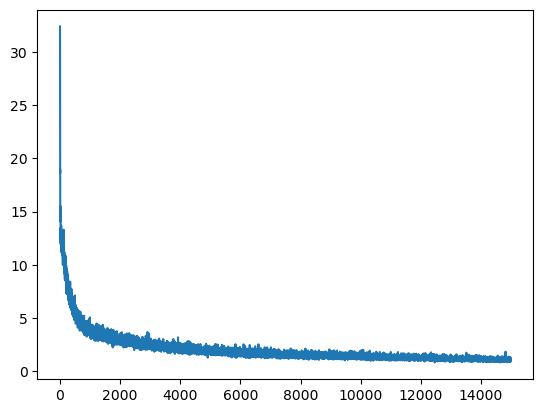

In [3]:
import matplotlib.pyplot as plt
print(ave_losses[-1])
plt.plot(ave_losses.numpy())

In [6]:
batch_size = tf.constant(int(5e4))

agent_distr = runner.get_normalized_agent_sample_distribution(batch_size)

grid_dim = 5
n_unique_samples = tf.shape(tf.where(agent_distr))[0]
frac_unique_coords = n_unique_samples / (grid_length ** grid_dim)
print(f"Percentage of coordinates sampled uniquely: {float(frac_unique_coords*100):.2f}%")

Percentage of coordinates sampled uniquely: 26.71%


In [7]:
env_distr = runner.env.rewards / tf.math.reduce_sum(runner.env.rewards)

In [8]:
import numpy as np

def _plot_l1_errors_per_probability_interval(agent_prob, env_prob, 
#                                              filename, 
                                             n_intervals
                                            ):
    result = agent_prob.ravel()
    expected = env_prob.ravel()
    max_expected = expected.max()
    expected_pcts = expected * 100 / max_expected

    interval_edges = np.linspace(0, 100, n_intervals + 1)
    starts = interval_edges[:-1]
    ends = interval_edges[1:]

    frac_l1_errors = np.abs(result - expected) / max_expected
    errors = []
    labels = []
    for s, e in zip(starts, ends):
        inds = np.where((s < expected_pcts) & (expected_pcts <= e))
        errors_per_interval = frac_l1_errors[inds]
        if len(errors_per_interval):
            interval_label = f"{s:.2f}% < pct <= {e:.2f}%"
            errors.append(errors_per_interval)
            labels.append(interval_label)

#     print(errors)
    fig, ax = plt.subplots()
    ax.violinplot(errors)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels, rotation=15)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Fractional L1 Errors")
    ax.set_xlabel("Percentage of max theoretical probability")
    plt.tight_layout()
#     fig.savefig(f"./plot_results/{filename}")
    return errors

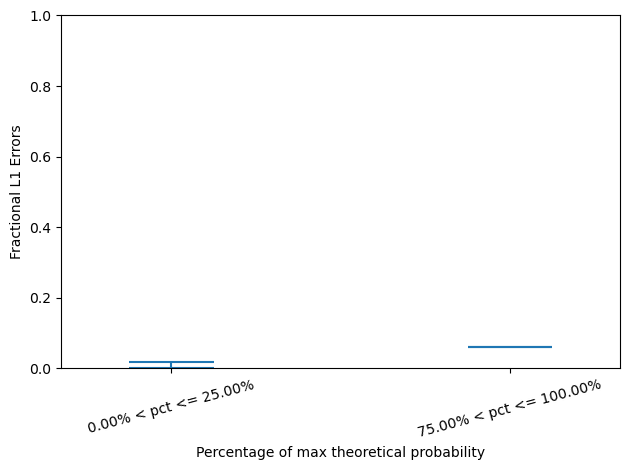

In [9]:
errors = _plot_l1_errors_per_probability_interval(
    agent_distr.numpy(), env_distr.numpy(), n_intervals=4
)

In [11]:
errors

[array([5.7635468e-04, 2.7919549e-04, 5.1134703e-04, ..., 2.1435235e-07,
        4.7912425e-05, 1.0551037e-03], dtype=float32),
 array([0.06084052], dtype=float32)]